# Maven NLP Course
Assignment 1, 10 May 2023

https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

Credit - https://www.kaggle.com/code/shuvojitdas/sentiment-analysis-using-twitter-airline-data

## Import Libraries

In [21]:
import pandas as pd
import seaborn as sns
import re, nltk
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from lime import lime_tabular
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

## Read & Review Data

In [24]:
import os
import pandas as pd

downloads_folder = os.path.join(os.path.expanduser('~'), 'Downloads')
file_path = os.path.join(downloads_folder, 'Tweets.csv')

twitter_df = pd.read_csv(file_path)
twitter_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [26]:
twitter_df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [37]:
twitter_df.shape

(14640, 15)

In [28]:
twitter_df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [29]:
# Check for and count the number of duplicate rows in the twitter_df DataFrame
twitter_df.duplicated().sum()

36

In [31]:
# Unique values of sentiment
twitter_df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [33]:
twitter_df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [36]:
twitter_df.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.685592e+17,5.694779e+17,5.698905e+17,5.703106e+17
airline_sentiment_confidence,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,3.606000e-01,6.706000e-01,1.000000e+00,1.000000e+00
retweet_count,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


array([[<Axes: title={'center': 'tweet_id'}>,
        <Axes: title={'center': 'airline_sentiment_confidence'}>],
       [<Axes: title={'center': 'negativereason_confidence'}>,
        <Axes: title={'center': 'retweet_count'}>]], dtype=object)

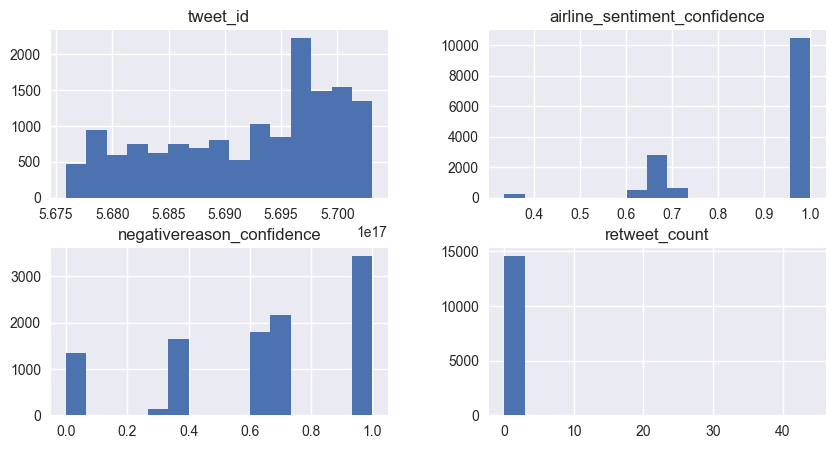

In [53]:
plt.style.use("seaborn")
twitter_df.hist(figsize=(10,5), bins=15)

<Axes: xlabel='airline_sentiment', ylabel='count'>

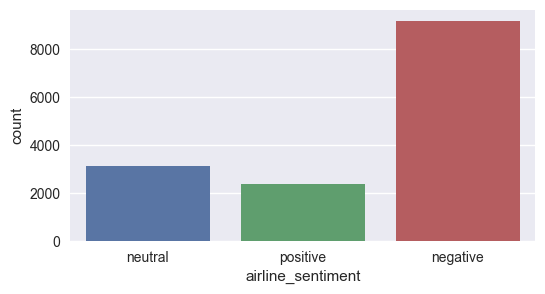

In [50]:
plt.figure(figsize=(6,3))
sns.countplot(x="airline_sentiment", data=twitter_df)

<Axes: xlabel='airline', ylabel='count'>

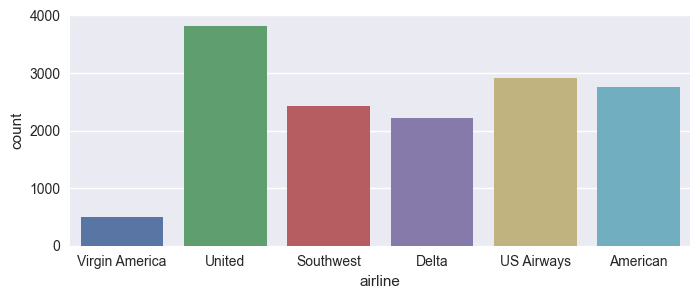

In [47]:
plt.figure(figsize=(8,3))
sns.countplot(x="airline", data=twitter_df)

<Axes: xlabel='retweet_count', ylabel='count'>

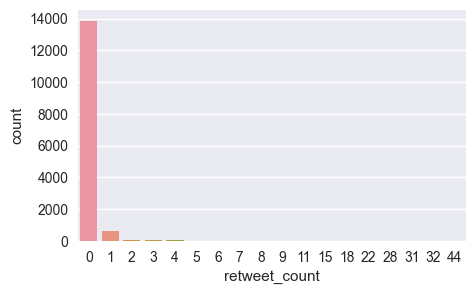

In [54]:
plt.figure(figsize=(5,3))
sns.countplot(x="retweet_count", data=twitter_df)

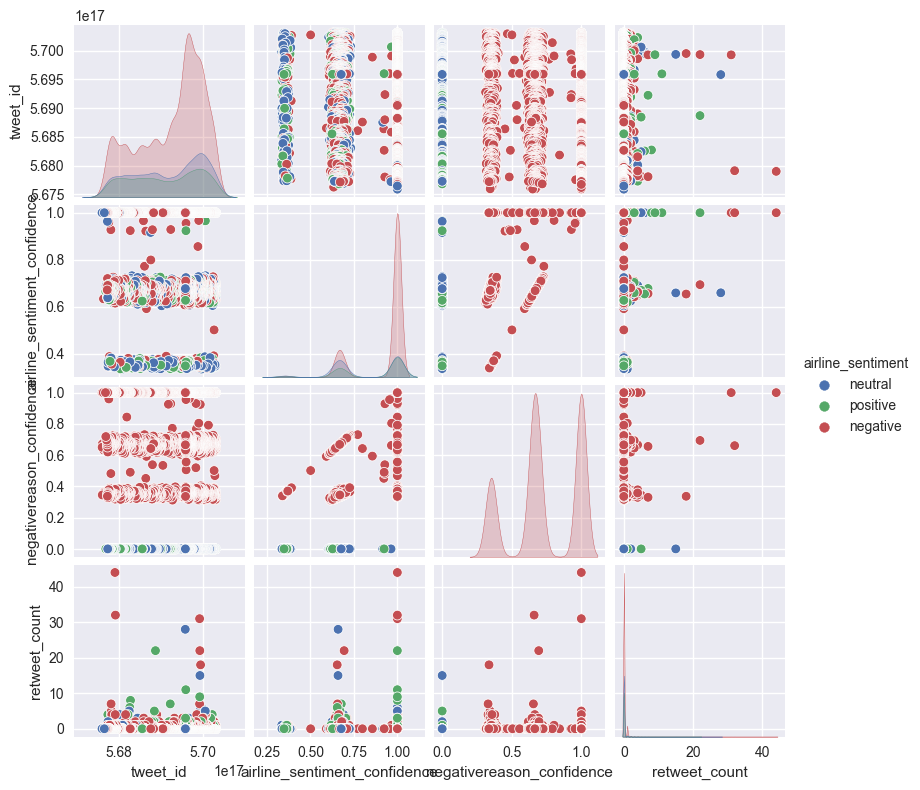

In [58]:
sns.pairplot(twitter_df,hue='airline_sentiment',height=2)

Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


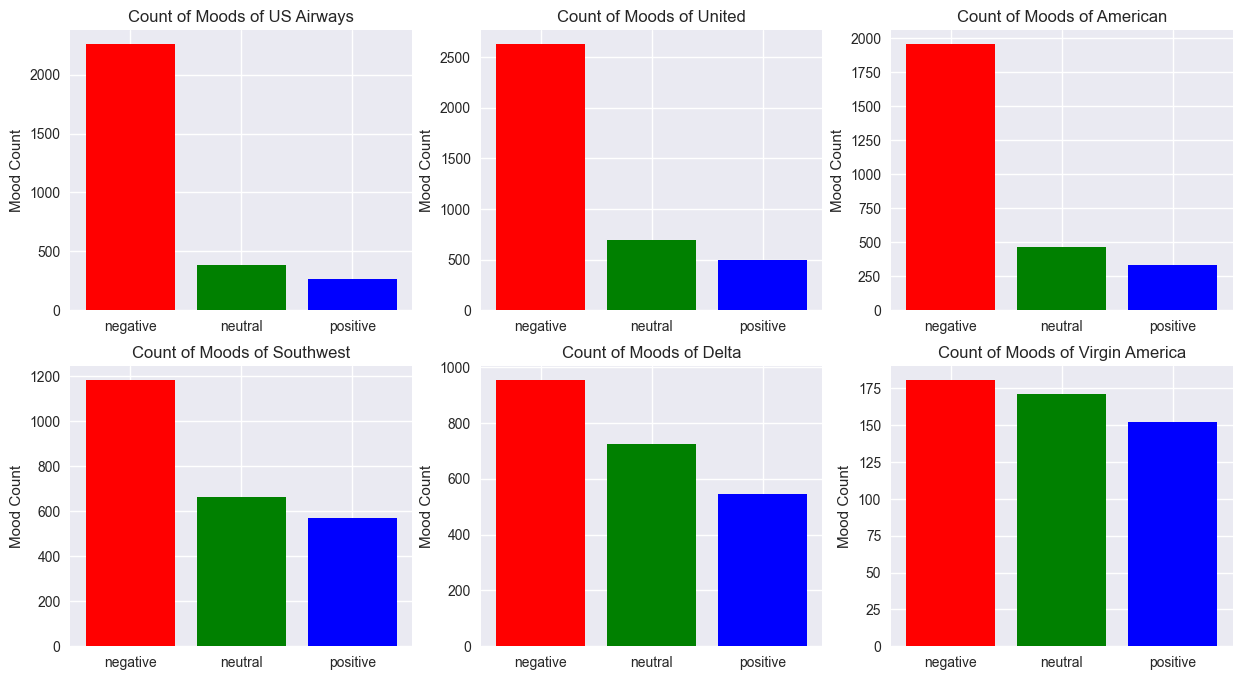

In [65]:
print("Total number of tweets for each airline \n ",twitter_df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(15,8))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=twitter_df[twitter_df['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    #plt.xlabel('Mood')
    plt.title(f'Count of Moods of {i}')

            Percent Negative
American            0.710402
Delta               0.429793
Southwest           0.490083
US Airways          0.776862
United              0.688906
Virgin              0.359127


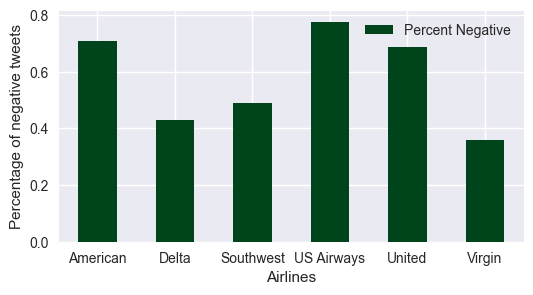

In [70]:
neg_tweets = twitter_df.groupby(['airline','airline_sentiment']).count().iloc[:,0]
total_tweets = twitter_df.groupby(['airline'])['airline_sentiment'].count()

my_dict = {'American':neg_tweets[0] / total_tweets[0],'Delta':neg_tweets[3] / total_tweets[1],'Southwest': neg_tweets[6] / total_tweets[2],
'US Airways': neg_tweets[9] / total_tweets[3],'United': neg_tweets[12] / total_tweets[4],'Virgin': neg_tweets[15] / total_tweets[5]}
perc = pd.DataFrame.from_dict(my_dict, orient = 'index')
perc.columns = ['Percent Negative']
print(perc)
ax = perc.plot(kind = 'bar', rot=0, colormap = 'Greens_r', figsize = (6,3))
ax.set_xlabel('Airlines')
ax.set_ylabel('Percentage of negative tweets')
plt.show()

<Axes: xlabel='airline'>

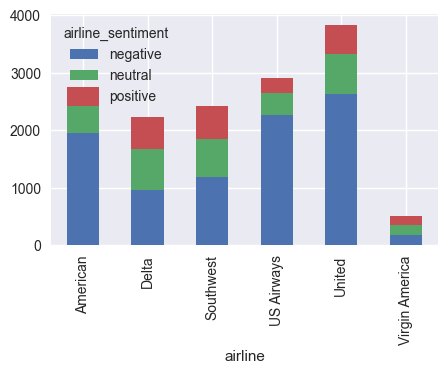

In [72]:
figure_2 = twitter_df.groupby(['airline', 'airline_sentiment']).size()
figure_2.unstack().plot(kind='bar', stacked=True, figsize=(5,3))

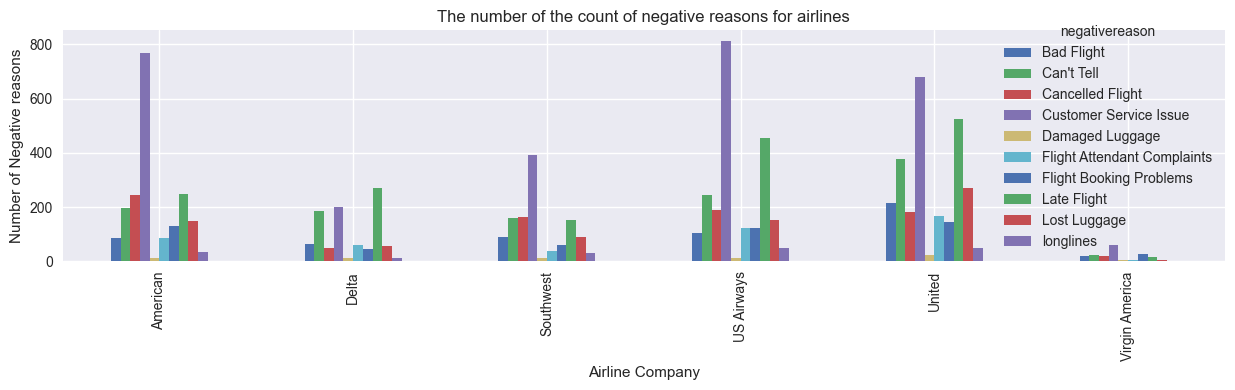

In [74]:
negative_reasons = twitter_df.groupby('airline')['negativereason'].value_counts(ascending=True)
negative_reasons.groupby(['airline','negativereason']).sum().unstack().plot(kind='bar',figsize=(15,3))
plt.xlabel('Airline Company')
plt.ylabel('Number of Negative reasons')
plt.title("The number of the count of negative reasons for airlines")
plt.show()

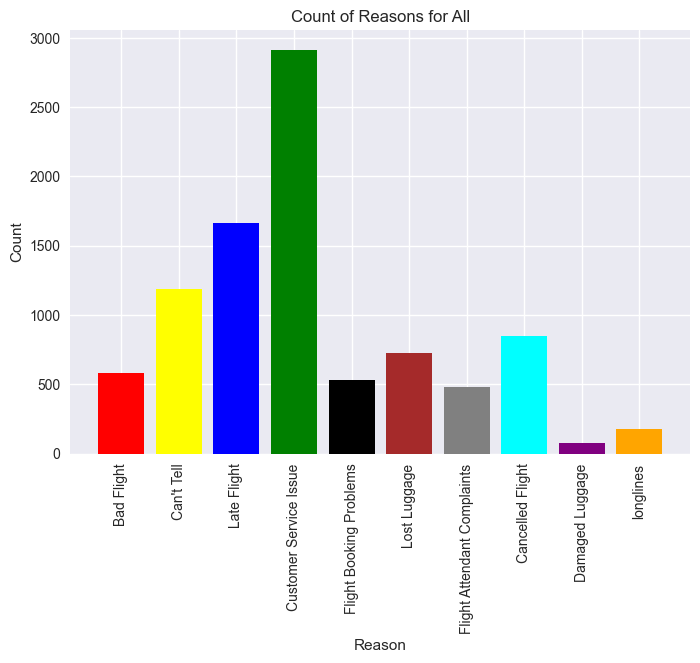

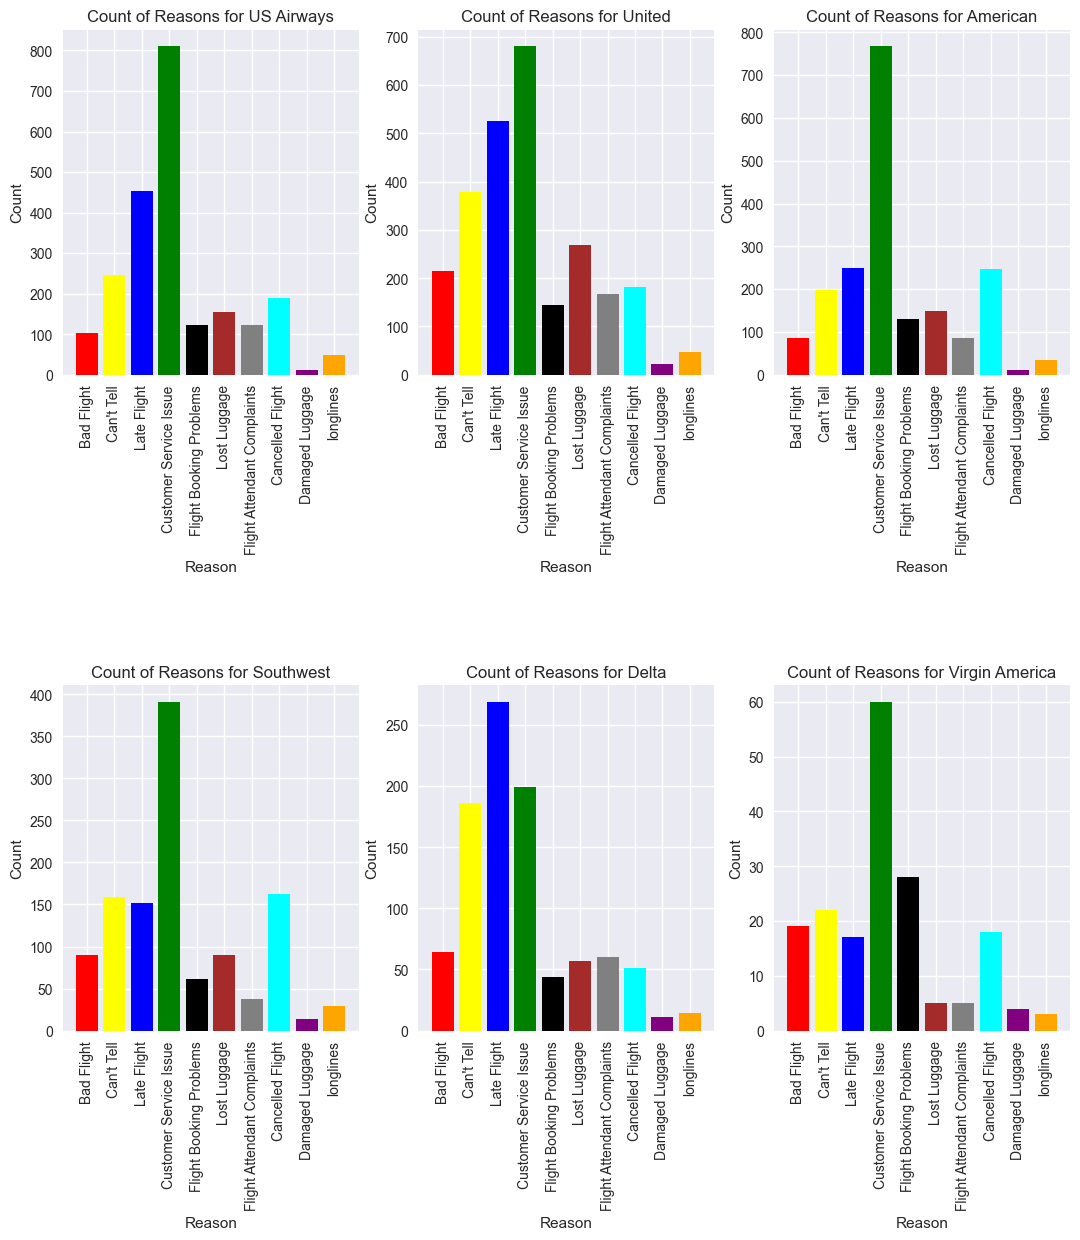

In [75]:
twitter_df['negativereason'].nunique()

NR_Count=dict(twitter_df['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All':
        a=twitter_df
    else:
        a=twitter_df[twitter_df['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(twitter_df['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame
def plot_reason(Airline):
    
    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)
    
plot_reason('All')
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

In [76]:
date = twitter_df.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
df = date
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()
# day_df = day_df.reset_index()
day_df

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64

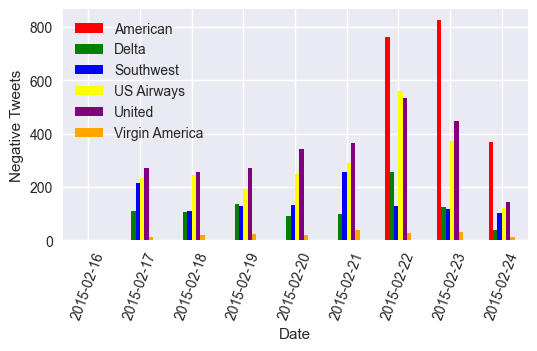

In [78]:
day_df = day_df.loc(axis=0)[:,:,'negative']

#groupby and plot data
ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['red', 'green', 'blue','yellow','purple','orange'], figsize = (6,3), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()

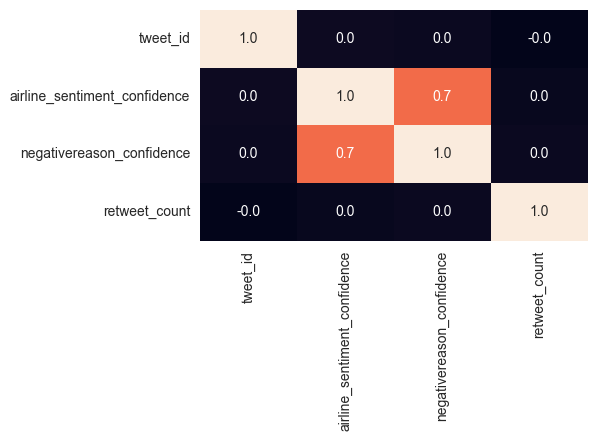

In [80]:
plt.figure(figsize=(5,3))
sns.heatmap(twitter_df.corr(),annot=True,cbar=False,fmt='.1f')
plt.show()

Text(0.5, 1.0, 'Features Correlating with airline sentiment confidence')

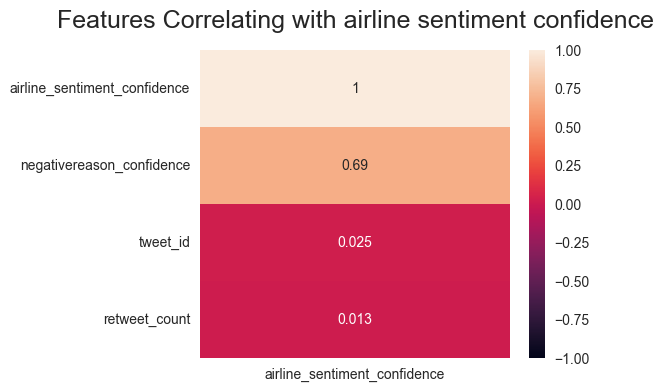

In [81]:
plt.figure(figsize=(5, 4))
heatmap = sns.heatmap(twitter_df.corr()[['airline_sentiment_confidence']].sort_values(by='airline_sentiment_confidence', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with airline sentiment confidence', fontdict={'fontsize':18}, pad=16)

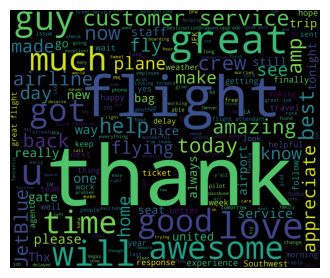

In [83]:
from wordcloud import WordCloud,STOPWORDS
new_df=twitter_df[twitter_df['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(4,4))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

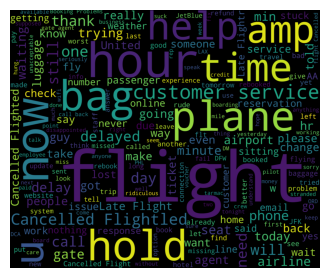

In [84]:
from wordcloud import WordCloud,STOPWORDS
new_df=twitter_df[twitter_df['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(4,4))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [86]:
def clean_the_tweet(text):
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens[2:])

                 

def text_process(msg):
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])


 
def check_scores(clf,X_train, X_test, y_train, y_test):

  model=clf.fit(X_train, y_train)
  predicted_class=model.predict(X_test)
  predicted_class_train=model.predict(X_train)
  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]
  yhat = model.predict(X_test)
  lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
  lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)


  print('Train confusion matrix is: ',)
  print(confusion_matrix(y_train, predicted_class_train))

  print()
  print('Test confusion matrix is: ')
  print(confusion_matrix(y_test, predicted_class))
  print()
  print(classification_report(y_test,predicted_class)) 
  print() 
  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)

  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print()
  train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
  test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

  print("Train ROC-AUC score: ", train_auc)
  print("Test ROC-AUC score: ", test_auc)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(lr_recall, lr_precision)
  ax1.set(xlabel="Recall", ylabel="Precision")

  plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  print()
  print('Are under Precision-Recall curve:', lr_f1)
  
  fpr, tpr, _ = roc_curve(y_test, test_probs)


  ax2.plot(fpr, tpr)
  ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

  print("Area under ROC-AUC:", lr_auc)
  return train_accuracy, test_accuracy, train_auc, test_auc



def grid_search(model, parameters, X_train, Y_train):
  #Doing a grid
  grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=2, scoring='roc_auc')
  #Fitting the grid 
  grid.fit(X_train,Y_train)
  print()
  print()
  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model

## Clean the data

In [87]:
df = df[df['airline_sentiment']!='neutral']
df['cleaned_tweet'] = df['text'].apply(clean_the_tweet)

df.head()
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x =='positive' else 0)
df.head()

,index,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
1,1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24,NaN,Pacific Time (US & Canada),you ve added commercials to the experience tacky
3,3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24,NaN,Pacific Time (US & Canada),s really aggressive to blast obnoxious enterta...
4,4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24,NaN,Pacific Time (US & Canada),it s a really big bad thing about it
5,5,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24,NaN,Pacific Time (US & Canada),would pay a flight for seats that didn t have ...
6,6,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24,San Francisco CA,Pacific Time (US & Canada),nearly every time i fly vx this ear worm won t...


In [ ]:
df['cleaned_tweet'] = df['cleaned_tweet'].apply(text_process)
df.reset_index(drop=True, inplace = True)
df.head()

In [ ]:
df['airline_sentiment'].unique()